# Overview

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [48]:
import numpy as np
import pandas as pd
from sklearn import tree, ensemble
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt

## Importing the data

In [2]:
df_test = pd.read_csv("test.csv")
df_train =pd.read_csv("train.csv")

In [3]:
df_test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [4]:
df_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


## Data Pre-processing

In [5]:
df_train['SalePrice'].dtype

dtype('int64')

In [6]:
df_test['SalePrice'] = -1

In [7]:
df_test['SalePrice'].dtype

dtype('int64')

In [8]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [9]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
nan_percentages = df.isnull().mean() * 100

# Sort the percentages in descending order
nan_percentages_sorted = nan_percentages.sort_values(ascending=False)

# Print the results
for column, percentage in nan_percentages_sorted.items():
    if percentage >= 0.5:
        print(f"{column}: {percentage:.2f}%")

PoolQC: 99.66%
MiscFeature: 96.40%
Alley: 93.22%
Fence: 80.44%
MasVnrType: 60.50%
FireplaceQu: 48.65%
LotFrontage: 16.65%
GarageFinish: 5.45%
GarageQual: 5.45%
GarageCond: 5.45%
GarageYrBlt: 5.45%
GarageType: 5.38%
BsmtExposure: 2.81%
BsmtCond: 2.81%
BsmtQual: 2.77%
BsmtFinType2: 2.74%
BsmtFinType1: 2.71%
MasVnrArea: 0.79%


## Dimension reduction and feature engineering

In [11]:
df = df.drop(['Id','PoolQC','MiscFeature','Fence','MasVnrType','FireplaceQu','LotFrontage','Alley'], axis=1)

### Imputation

In [12]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

In [13]:
categorical_columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [14]:
df[categorical_columns]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,...,SBrkr,TA,Typ,NaN,NaN,NaN,NaN,Y,WD,Normal
2915,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,...,SBrkr,TA,Typ,CarPort,Unf,TA,TA,Y,WD,Abnorml
2916,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
2917,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,SBrkr,TA,Typ,NaN,NaN,NaN,NaN,Y,WD,Normal


In [15]:
ordinal_encoder = OrdinalEncoder()

In [16]:
df_encoded = df.copy()
if len(categorical_columns) > 0:
    df_encoded[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])

In [17]:
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0
)
imputed_data = imputer.fit_transform(df_encoded)

In [18]:
# Convert the imputed data back to a DataFrame
df_imputed = pd.DataFrame(imputed_data, columns=df.columns)

In [19]:
if len(categorical_columns) > 0:
    df_imputed[categorical_columns] = ordinal_encoder.inverse_transform(df_imputed[categorical_columns])

In [20]:
df_imputed

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,RL,8450.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,9600.0,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,11250.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,9550.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,14260.0,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160.0,RM,1936.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,WD,Normal,-1.0
2915,160.0,RM,1894.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,WD,Abnorml,-1.0
2916,20.0,RL,20000.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,WD,Abnorml,-1.0
2917,85.0,RL,10441.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,WD,Normal,-1.0


In [21]:
df_imputed = pd.get_dummies(df_imputed)
#df_imputed = df_imputed.reset_index(drop=True)
df_imputed

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,False,False,False,True,False,False,False,False,True,False
1,20.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,False,False,False,True,False,False,False,False,True,False
2,60.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,...,False,False,False,True,False,False,False,False,True,False
3,70.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,...,False,False,False,True,True,False,False,False,False,False
4,60.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160.0,1936.0,4.0,7.0,1970.0,1970.0,0.0,0.0,0.0,546.0,...,False,False,False,True,False,False,False,False,True,False
2915,160.0,1894.0,4.0,5.0,1970.0,1970.0,0.0,252.0,0.0,294.0,...,False,False,False,True,True,False,False,False,False,False
2916,20.0,20000.0,5.0,7.0,1960.0,1996.0,0.0,1224.0,0.0,0.0,...,False,False,False,True,True,False,False,False,False,False
2917,85.0,10441.0,5.0,5.0,1992.0,1992.0,0.0,337.0,0.0,575.0,...,False,False,False,True,False,False,False,False,True,False


In [22]:
categorical_columns_imputed = df_imputed.select_dtypes(exclude=[np.number]).columns
categorical_columns_imputed

Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=230)

In [23]:
df_imputed['MSZoning_RL']

0        True
1        True
2        True
3        True
4        True
        ...  
2914    False
2915    False
2916     True
2917     True
2918     True
Name: MSZoning_RL, Length: 2919, dtype: bool

In [24]:
nan_percentages = df_imputed.isnull().mean() * 100

# Sort the percentages in descending order
nan_percentages_sorted = nan_percentages.sort_values(ascending=False)

# Print the results
for column, percentage in nan_percentages_sorted.items():
    print(f"{column}: {percentage:.2f}%")

MSSubClass: 0.00%
BsmtCond_Po: 0.00%
ExterCond_Po: 0.00%
ExterCond_TA: 0.00%
Foundation_BrkTil: 0.00%
Foundation_CBlock: 0.00%
Foundation_PConc: 0.00%
Foundation_Slab: 0.00%
Foundation_Stone: 0.00%
Foundation_Wood: 0.00%
BsmtQual_Ex: 0.00%
BsmtQual_Fa: 0.00%
BsmtQual_Gd: 0.00%
BsmtQual_TA: 0.00%
BsmtCond_Fa: 0.00%
BsmtCond_Gd: 0.00%
BsmtCond_TA: 0.00%
BsmtFinType2_Unf: 0.00%
BsmtExposure_Av: 0.00%
BsmtExposure_Gd: 0.00%
BsmtExposure_Mn: 0.00%
BsmtExposure_No: 0.00%
BsmtFinType1_ALQ: 0.00%
BsmtFinType1_BLQ: 0.00%
BsmtFinType1_GLQ: 0.00%
BsmtFinType1_LwQ: 0.00%
BsmtFinType1_Rec: 0.00%
BsmtFinType1_Unf: 0.00%
BsmtFinType2_ALQ: 0.00%
BsmtFinType2_BLQ: 0.00%
BsmtFinType2_GLQ: 0.00%
BsmtFinType2_LwQ: 0.00%
ExterCond_Gd: 0.00%
ExterCond_Fa: 0.00%
ExterCond_Ex: 0.00%
ExterQual_TA: 0.00%
Exterior1st_CemntBd: 0.00%
Exterior1st_HdBoard: 0.00%
Exterior1st_ImStucc: 0.00%
Exterior1st_MetalSd: 0.00%
Exterior1st_Plywood: 0.00%
Exterior1st_Stone: 0.00%
Exterior1st_Stucco: 0.00%
Exterior1st_VinylSd: 0.0

In [25]:
columns = df_imputed.columns.to_list()
columns.remove('SalePrice')
df_imputed = df_imputed[columns + ['SalePrice']]

In [26]:
df_imputed.head(2)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,False,False,True,False,False,False,False,True,False,208500.0
1,20.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,False,False,True,False,False,False,False,True,False,181500.0


## Data Partitioning

In [27]:
df_train = df_imputed[df_imputed['SalePrice'] != -1]
df_test = df_imputed[df_imputed['SalePrice'] == -1]

In [28]:
df_train['SalePrice'].dtype

dtype('float64')

In [29]:
(df_train['SalePrice'] == -1).sum()

0

In [30]:
(df_test['SalePrice'] != -1).sum()

0

In [31]:
df_test = df_test.drop('SalePrice', axis=1)

In [32]:
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice']

## Train and Test

In [33]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
X_test = df_test  # df_test should already have 'SalePrice' dropped
y_pred = rf_reg.predict(X_test)

In [35]:
y_pred

array([130351.  , 156235.  , 185294.34, ..., 154578.62, 114948.13,
       223921.45])

In [36]:
output_rf_reg = pd.DataFrame({
    'Id': df_test.index.astype('int32')+1,  # Ensure 'Id' is integer
    'SalePrice': y_pred.flatten()
})

In [37]:
output_rf_reg

,Id,SalePrice
0,1461,130351.00
1,1462,156235.00
2,1463,185294.34
3,1464,183738.00
4,1465,196619.69
...,...,...
1454,2915,84760.93
1455,2916,88130.82
1456,2917,154578.62
1457,2918,114948.13


In [38]:
output_rf_reg.to_csv('rf_predictions.csv', index=False)

In [39]:
# If you want to evaluate the model (you'll need a portion of training data for this)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
rf_reg.fit(X_train, y_train)
y_val_pred = rf_reg.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# Now you can use rf_reg to make predictions on your test set
final_predictions = rf_reg.predict(X_test)

Mean Squared Error: 856362768.6540877
R2 Score: 0.8883538006699543


In [44]:
importances = rf_reg.feature_importances_
feature_names = X_train.columns

In [45]:
indices = np.argsort(importances)[::-1]

In [46]:
top_k = 20
top_features = feature_names[indices][:top_k]
top_importances = importances[indices][:top_k]

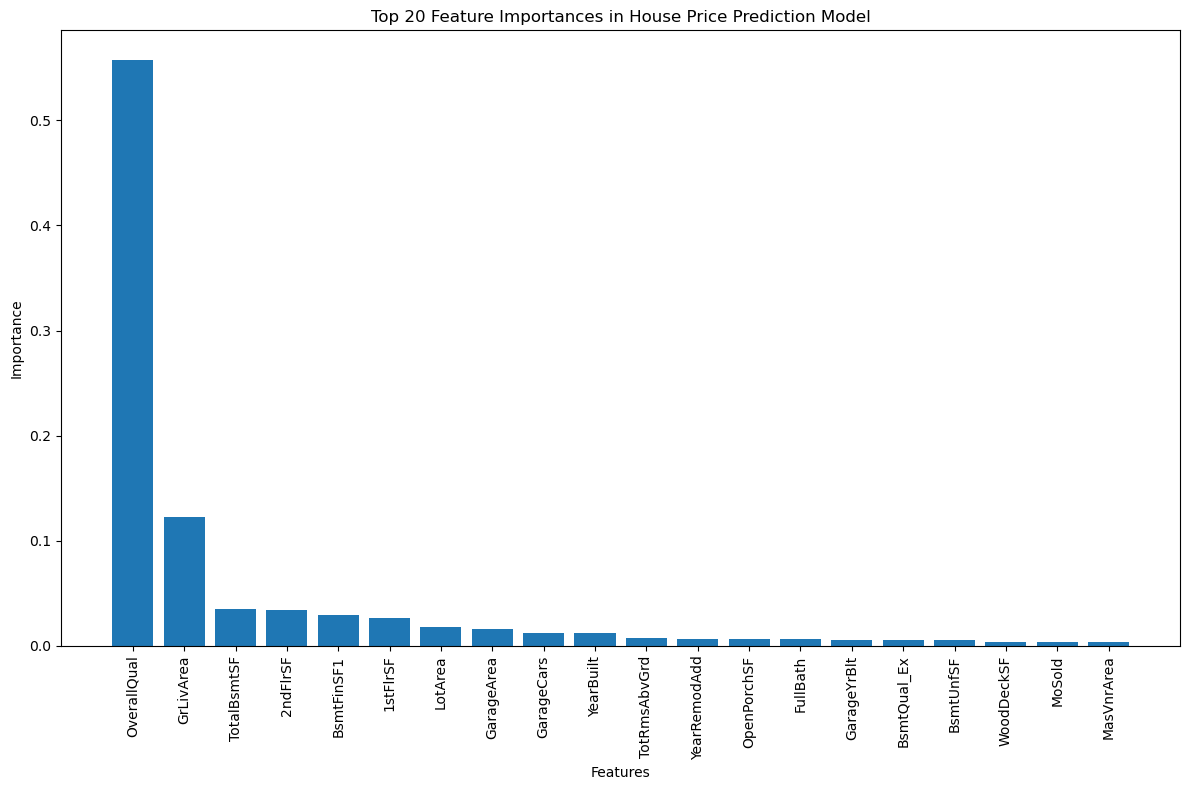

In [49]:
plt.figure(figsize=(12, 8))
plt.title("Top 20 Feature Importances in House Price Prediction Model")
plt.bar(range(top_k), top_importances)
plt.xticks(range(top_k), top_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()

In [ ]:
plt.show()